<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Ahn_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request

In [ ]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

# control genes
genes_c = genes[(pd.isna(genes.sym)) & (pd.isna(genes.chrom))]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 2.0 MB/s 


# Data Preparation

`michigan` dataset contains the measurements, done at University of Michigan lab, of anterior cortex and dorsolateral cortex for each patient. 

`michigan_diff` subtracts measurement of anterior cortex from the dorsolateral cortex for each patient.

In [ ]:
# Michigan
michigan = expression[(expression.index.str[5] == 'M') & (expression.index.str[3] != 'c') ]
michigan_diff = michigan.diff().iloc[1::2,:]
michigan_diff.index = "patient" + michigan_diff.index.str[:2]
#michigan_diff

# Davis
davis = expression[(expression.index.str[5] == 'D') & (expression.index.str[3] != 'c') ]
davis = davis[~davis.index.str[1].isin(['1', '2', '5', '6', '7', '9'])]
#davis

# Irvine
irvine = expression[(expression.index.str[5] == 'I') & (expression.index.str[3] != 'c') ]
irvine_diff = irvine.diff().iloc[1::2,:]
irvine_diff.index = "patient" + irvine_diff.index.str[:2]
#irvine_diff

# Hypothesis testing 
Wilcoxon signed-rank test/paired t-test for each gene excluding controls
Tests whether the median of the difference is 0/mean of the difference is 0.  
Wilcoxon signed-rank test: A non-parametric alternative test to the paired t-test. 

## Multiple Hypotheses Testing on the actual data

In [ ]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

def testing(df, centered, lab, mode):
  
  '''
  do Wilcoxon signed-rank test for each gene. 
  Make either Bonferroni or Benjamini-Hochberg correction when doing the multiple testing

  args:
  -----
  df: data frame without the controls
  centered: True/False(T: centered, F: not centered/actual)
  lab: should be one of 'michigan', 'irvine', 'davis'
  mode: 'w' if Wilcoxon-signed-rank test, 't' if paired t-test
  '''

  if (mode=='w'):
    p_val = df.apply(wilcoxon).iloc[1,:]
    print(lab)
    print('Wilcoxon signed-rank test')
    print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))
  else:
    p_val = [ttest_1samp(df.iloc[:,i], 0)[1] for i in np.arange(df.shape[1])]
    print(lab)
    print('Paired t-test')
    print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))

  bonferr = multipletests(p_val, method='bonferroni')[0]
  bh = multipletests(p_val, method='fdr_bh')[0] 

  # Storing
  if centered:
    pvals_c['_'.join([lab, 'c', mode])] = p_val
    rejected_c['_'.join([lab, 'c', mode])+'_b'] = bonferr 
    rejected_c['_'.join([lab, 'c', mode])+'_bh'] = bh  
  else:
    pvals['_'.join([lab, mode])] = p_val
    rejected['_'.join([lab, mode])+'_b'] = bonferr 
    rejected['_'.join([lab, mode])+'_bh'] = bh  

  print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
  print('rejected H0(BH):{} \n'.format(sum(bh)))
  plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Michigan')
  plt.legend()

michigan
Wilcoxon signed-rank test
rejected H0(no correction):11181
rejected H0(bonferroni):0
rejected H0(BH):11122 

irvine
Wilcoxon signed-rank test
rejected H0(no correction):10
rejected H0(bonferroni):0
rejected H0(BH):0 



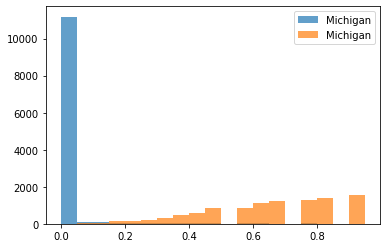

In [ ]:
# `pvals` stores the pvalues, `rejected` stores the rejected H0 from the multiple hypothesis testing
pvals = {}
rejected = {}

# Remove controls
michigan_diff = michigan_diff[[c for c in michigan_diff.columns if c not in genes_c.index]]
irvine_diff = irvine_diff[[c for c in irvine_diff.columns if c not in genes_c.index]]

testing(michigan_diff, False, 'michigan', 'w')
testing(irvine_diff, False, 'irvine', 'w')

michigan
Paired t-test
rejected H0(no correction):11206
rejected H0(bonferroni):458
rejected H0(BH):11196 

irvine
Paired t-test
rejected H0(no correction):4
rejected H0(bonferroni):0
rejected H0(BH):0 



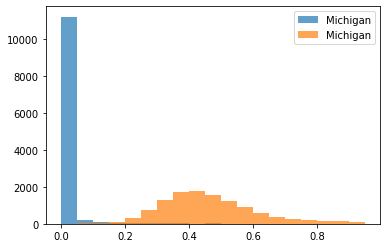

In [ ]:
testing(michigan_diff, False, 'michigan', 't')
testing(irvine_diff, False, 'irvine', 't')

## Multiple Hypothesis testing on the centered data
Lab-wise
1. Compute average measurements of the controls for each microarray. We assume the bacterial controls contain information about the microarray effect.
2. Centering: subtract the control average for each gene.
3. Do multiple hypothesis testing 


In [ ]:
# Data Centering 

# Michigan
control_m = michigan[genes_c.index].apply(np.mean, axis=1)
michigan_c = michigan.sub(control_m, axis='rows')
michigan_c_diff = michigan_c.diff().iloc[1::2,:]
michigan_c_diff.index = "patient" + michigan_c_diff.index.str[:2]

# Irvine
control_i = irvine[genes_c.index].apply(np.mean, axis=1)
irvine_c = irvine.sub(control_i, axis='rows')
irvine_c_diff = irvine_c.diff().iloc[1::2,:]
irvine_c_diff.index = "patient" + irvine_c_diff.index.str[:2]

michigan
Wilcoxon signed-rank test
rejected H0(no correction):5005
rejected H0(bonferroni):0
rejected H0(BH):3648 

irvine
Wilcoxon signed-rank test
rejected H0(no correction):405
rejected H0(bonferroni):0
rejected H0(BH):0 



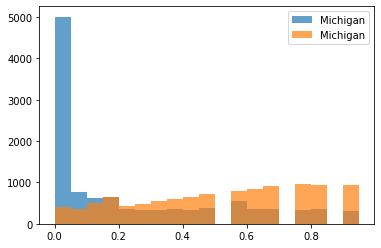

In [ ]:
# Remove controls
michigan_c_diff = michigan_c_diff[[c for c in michigan_c_diff.columns if c not in genes_c.index]]
irvine_c_diff = irvine_c_diff[[c for c in irvine_c_diff.columns if c not in genes_c.index]]

pvals_c = {}
rejected_c = {}

testing(michigan_c_diff, True, 'michigan', 'w')
testing(irvine_c_diff, True, 'irvine', 'w')

michigan
Paired t-test
rejected H0(no correction):5274
rejected H0(bonferroni):227
rejected H0(BH):3915 

irvine
Paired t-test
rejected H0(no correction):385
rejected H0(bonferroni):0
rejected H0(BH):0 



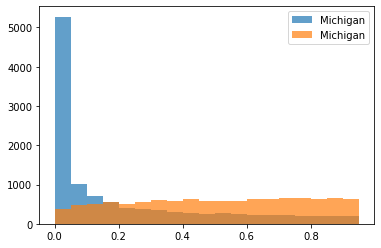

In [ ]:
testing(michigan_c_diff, True, 'michigan', 't')
testing(irvine_c_diff, True, 'irvine', 't')

## Multiple Hypothesis Testing results
The keys are represented as : {lab}_{wilcoxon/t-test}_{bonferroni/B-H}.  
The cotrol centered data gives the results that we expect.

In [ ]:
print('# of rejected H0 using the actual data')
print(pd.DataFrame(rejected).apply(np.sum))

print('# of rejected H0 using the centered data')
print(pd.DataFrame(rejected_c).apply(np.sum))


# of rejected H0 using the actual data
michigan_w_b         0
michigan_w_bh    11122
irvine_w_b           0
irvine_w_bh          0
michigan_t_b       458
michigan_t_bh    11196
irvine_t_b           0
irvine_t_bh          0
dtype: int64
# of rejected H0 using the centered data
michigan_w_b        0
michigan_w_bh    3648
irvine_w_b          0
irvine_w_bh         0
michigan_t_b      227
michigan_t_bh    3915
irvine_t_b          0
irvine_t_bh         0
dtype: int64


Do the same procedure on the aggregated (Michigan + Irvine) data

Wilcoxon signed-rank test
rejected H0(no correction):3595
rejected H0(bonferroni):3
rejected H0(BH):1370 

paired t-test
rejected H0(no correction):4005
rejected H0(bonferroni):7
rejected H0(BH):1547 



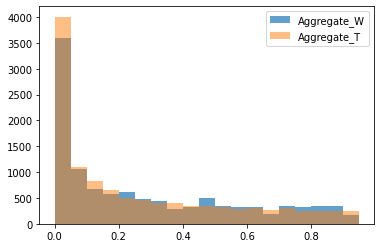

In [ ]:
df = pd.concat([michigan_c_diff, irvine_c_diff])  # Row index not adjusted

# Wilcoxon signed-rank test
p_val = df.apply(wilcoxon).iloc[1,:] 
bonferr = multipletests(p_val, method='bonferroni')[0]  
bh = multipletests(p_val, method='fdr_bh')[0]  
print('Wilcoxon signed-rank test')
print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Aggregate_W')


# Paired t-test
p_val = [ttest_1samp(df.iloc[:,i], 0)[1] for i in np.arange(df.shape[1])]
bonferr = multipletests(p_val, method='bonferroni')[0]  
bh = multipletests(p_val, method='fdr_bh')[0]   
print('paired t-test')
print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.5, label='Aggregate_T')
plt.legend()


# Gene Investigation
Investigate genes(227): centered data from Michigan lab using paired t-test w/ bonferroni correction: michigan_c_t_b 

In [ ]:
g = michigan_c_diff.columns[rejected_c['michigan_c_t_b']]
g_pval = np.array(pvals_c['michigan_c_t'])
g_pval = g_pval[np.array(rejected_c['michigan_c_t_b'])]
genes.loc[g]

,sym,chrom
1138_at,SLC20A1,2
1158_s_at,CALM3,19
1225_g_at,PCTK1,X
1233_s_at,AXL,19
1310_at,PSMB2,1
...,...,...
765_s_at,LGALS4,19
799_at,CDK5R1,17
818_s_at,ATRX,X
838_s_at,UBE2I,16


In [ ]:
genes.loc[g].groupby('chrom').size().sort_values(ascending=False)

chrom
1          25
6          17
17         16
19         15
12         14
16         13
2          12
15         12
X          11
9          10
7          10
22         10
20          9
11          9
8           8
3           7
4           7
10          7
5           5
14          4
13          2
21          2
18          2
7ps*        0
10ak*       0
Un          0
X Y         0
10ptp*      0
Y           0
16nomo1     0
45ac*       0
7cb*        0
11hbg       0
16hba1      0
22gp*       0
22gg*       0
15ch*       0
17loc*      0
na          0
dtype: int64